# Plot figure for validation of groups

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

```
cd <my_path>/gud_groups
conda env create -f binder/environment.yml
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda activate gud_groups
jupyter notebook
```

Once the environment gud_groups is created, the Jupyter notebook can be launched simply with:

```
cd <my_path>/gud_groups/output/run_20230707_0000_EXP0_translucent_snow
conda activate gud_groups
jupyter notebook
```

# First, load libraries

In [1]:
import datetime
import math
import matplotlib as mpl
import matplotlib.patches
import matplotlib.pyplot as plt
import netcdf_tools
import numpy as np
import pandas as pd
import pathlib
import os
import read_mitgcm
import scipy.interpolate
import statsmodels.nonparametric.smoothers_lowess
import tarfile
import vstats_pos

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
plt.close("all")

# Select year

In [4]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [5]:
gridfile='grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [6]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [7]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

# Observations

Create directory validation if it doesn't exit.

In [8]:
pathlib.Path("validation").mkdir(parents=True, exist_ok=True)

## Observations: sea ice concentration

The values of observed sea ice concentrations were boolean values of 0
and 1 because sea ice melted suddenly in only one day.
Here, these values were retrieved from the file of the forcing fields
of sea ice concentration.
We made sure these values corresponded to the expected values.

In [9]:
infile_sic=\
'../../gud_1d_35+16/input_noradtrans/input/siarea.qik.2016.365.32bits.bin'
array1d_iT_sic=np.fromfile(infile_sic,dtype='>f')

Sea ice break-up was on 18 July 2016, doy (0-based)=199.

In [10]:
obs_breakup=next(i for i,v in list(enumerate(array1d_iT_sic)) if v==0)

assert obs_breakup==199,\
'the day of year (0-based) of break-up from the file %s (obs_breakup=%r)'\
' is different from the day of year of break-up'\
' from Oziel et al., 2019 in Elem. Sci. Anth. (July 18=199).'\
% (infile_sic,obs_breakup)

## Observations: snow and ice thickness

The file Ice thickness from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ snow and ice thickness at the Green Edge sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'sample_thickness_cm_average' is the snow or ice thickness ($cm$).

### Observations: snow and ice thickness: load dataset

In [11]:
def load_thickness():
    fname='../../obs/66407.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_thickness_cm_average': np.float32,
                'sample_thickness_cm_sd': np.float32,
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    df['sample_thickness_m_average']=df['sample_thickness_cm_average'] \
    .apply(lambda x:x/100)
    return df

In [12]:
thickness_df=load_thickness()

### Observations: snow and ice thickness: select

We select the observations of snow thickness at the ice camp 2016.

In [13]:
snow_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                               & (thickness_df.sample_type=='snow')]
# snow_thickness_df[['date','sample_thickness_m_average']]

The start of the period without observed snow cover was defined as the
start of the melt pond period.
It was on 15 June 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [14]:
obs_nosnow=166 # 0-based

We select the observations of ice thickness at the ice camp 2016.

In [15]:
ice_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                              & (thickness_df.sample_type=='ice')]

## Observations: PAR

In $\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

Conversion factor from
$\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$
to
$\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

In [16]:
uEs2Ed=1E-6*86400

The file C-OPS from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ underwater PAR at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'averaged_par_d_fit_daily_ein_m_2_day_1' is the downwelling PAR (mol photons $\mathrm{ m^{-2} }$ $\mathrm{ d^{-1} }$).

Let $\mathrm{ I_i }$ the PAR just below sea ice.

PAR just below surface ($\mathrm{ 0^- }$) was observed only just
below sea ice ($\mathrm{ I_i }$).
PAR just below surface ($\mathrm{ 0^- }$) was not observed just
below open water ($\mathrm{ I_w }$).
Observed PAR ($\mathrm{ 0^- }$) was thus equivalent to 
observed PAR just below sea ice ($\mathrm{ I_i })$.

### Observations: PAR: load dataset

In [17]:
def load_par(fname):
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [18]:
infile_PAR_iceFile='../../obs/66399.csv'
par_df=load_par(infile_PAR_iceFile)

### Observations: PAR: select

In [19]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [20]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [21]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

### Observations: PAR: calculate

The first value of simulated PAR had a depth=0 m even when there was sea ice. The first value of observed PAR had a depth equals to the thickness of sea ice in the water. For example, if there was 1 m of sea ice in the water, the first value of observed PAR would be at depth=1 m. We changed that for a depth=0 m to be coherent with the simulated values. Indeed, we wanted to compare observed and simulated PAR at the same distance from the bottom of sea ice and not at the same distance from the water surface.

In [22]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=parwater_df.loc[(parwater_df.doy==doy),('depth')].min() # m
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']-ice_thickness

In [23]:
# mol photons m^-2 d^-1
array1d_iT_obsPAR0m=np.empty(365)
array1d_iT_obsPAR0m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    array1d_iT_obsPAR0m[doy-1]=\
    parwater_df.loc[(parwater_df.doy==doy) & (parwater_df.depth==0),
                    'par']

The first observation of PAR under sea ice was on 4 May,
doy (0-based)=124.

In [24]:
first_obs_PAR=np.where(~np.isnan(array1d_iT_obsPAR0m))[0][0]
first_obs_PAR
assert first_obs_PAR==124,\
'the day of year (0-based) of the first observation of PAR under sea ice'\
' from the file %s (first_obs_PAR=%r)'\
' is different from the expected value of 124 (May 4).'\
% (infile_PAR_iceFile,first_obs_PAR)

## Observations: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated carbon (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

The dataset is available from https://www.seanoe.org/data/00487/59892/ : Photosynthetic picoeukaryotes (abundance) & Phytoplankton measured by Imaging FlowCytobot. The principal investigators were Joannie Ferland, Pierre-Luc Grondin and Marcel Babin.

Reference:
Massicotte, P., Amiraux, R., Amyot, M.-P., Archambault, P., Ardyna, M., Arnaud, L., Artigue, L., Aubry, C., Ayotte, P., Bécu, G., Bélanger, S., Benner, R., Bittig, H. C., Bricaud, A., Brossier, É., Bruyant, F., Chauvaud, L., Christiansen-Stowe, D., Claustre, H., Cornet-Barthaux, V., Coupel, P., Cox, C., Delaforge, A., Dezutter, T., Dimier, C., Domine, F., Dufour, F., Dufresne, C., Dumont, D., Ehn, J., Else, B., Ferland, J., Forget, M.-H., Fortier, L., Galí, M., Galindo, V., Gallinari, M., Garcia, N., Gérikas Ribeiro, C., Gourdal, M., Gourvil, P., Goyens, C., Grondin, P.-L., Guillot, P., Guilmette, C., Houssais, M.-N., Joux, F., Lacour, L., Lacour, T., Lafond, A., Lagunas, J., Lalande, C., Laliberté, J., Lambert-Girard, S., Larivière, J., Lavaud, J., LeBaron, A., Leblanc, K., Le Gall, F., Legras, J., Lemire, M., Levasseur, M., Leymarie, E., Leynaert, A., Lopes dos Santos, A., Lourenço, A., Mah, D., Marec, C., Marie, D., Martin, N., Marty, C., Marty, S., Massé, G., Matsuoka, A., Matthes, L., Moriceau, B., Muller, P.-E., Mundy, C.-J., Neukermans, G., Oziel, L., Panagiotopoulos, C., Pangrazi, J.-J., Picard, G., Picheral, M., Pinczon du Sel, F., Pogorzelec, N., Probert, I., Quéguiner, B., Raimbault, P., Ras, J., Rehm, E., Reimer, E., Rontani, J.-F., Rysgaard, S., Saint-Béat, B., Sampei, M., Sansoulet, J., Schmechtig, C., Schmidt, S., Sempéré, R., Sévigny, C., Shen, Y., Tragin, M., Tremblay, J.-É., Vaulot, D., Verin, G., Vivier, F., Vladoiu, A., Whitehead, J., and Babin, M.: Green Edge ice camp campaigns: understanding the processes controlling the under-ice Arctic phytoplankton spring bloom, Earth Syst. Sci. Data, 12, 151–176, https://doi.org/10.5194/essd-12-151-2020, 2020.

### Observations: $\mathrm{ \sum C_{phyto} }$: load dataset

In [25]:
def load_groups():
    fname='../../obs/66408.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_name': 'string',
                'sample_type': 'category',
                'depth_m': np.float32,
                'sample_source': 'category',
                'snow_thickness': 'category',
                'ml_analyzed': np.float32,
                'dilution_factor': np.float32,
                'taxonomy': 'category',
                'carbon_estimate_mg_c_m3': np.float32,
                'nb_images_img_ml': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [26]:
groups_df=load_groups()

In [27]:
#doy: 120
depths_case1 =np.array([       1.5,  5])
weights_case1=np.array([       3.25, 96.75])
#doy: 123
depths_case2 =np.array([       1.5,  5,    10,    20,     40])
weights_case2=np.array([       3.25, 4.25,  7.5,  15,     70])
#doy: 125
depths_case3 =np.array([0,           5,    10,    20])
weights_case3=np.array([2.5,         5,     7.5,  85])
#doy: 127,130,134,141,144,153,155,158,160,162,165,167,169,172,174,176
depths_case4 =np.array([0,     1.5,  5,    10,    20,     40])
weights_case4=np.array([0.75,  2.5,  4.25,  7.5,  15,     70])
#doy: 132
depths_case5 =np.array([0,     1.5,  5,    10,            40])
weights_case5=np.array([0.75,  2.5,  4.25, 17.5,          75])
#doy: 137,139
depths_case6 =np.array([0,     1.5,  5,    10,    20])
weights_case6=np.array([0.75,  2.5,  4.25,  7.5,  85])
#doy: 179,181,183,186,188,190
depths_case7 =np.array([0,     1.5,        10,    20, 30,     60])
weights_case7=np.array([0.75,  5,           9.25, 10, 20,     55])
#doy: 193,195,200
depths_case8 =np.array([     1.5,         10,    20, 30,      60,   75])
weights_case8=np.array([     5.75,         9.25, 10, 20,      22.5, 32.5])
#doy: 197,182
depths_case9 =np.array([     1.5,        10,    20, 30,   45, 60])
weights_case9=np.array([     5.75,        9.25, 10, 12.5, 15, 47.5])

### Observations: $\mathrm{ \sum C_{phyto} }$: diatoms

We select the observations of diatoms at the Green Edge Sea Ice Camp in 2016.

In [28]:
diatomsnotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Attheya') \
    | (groups_df.taxonomy=='Centric diatoms') \
    | (groups_df.taxonomy=='Centric diatoms chains') \
    | (groups_df.taxonomy=='Chaetoceros') \
    | (groups_df.taxonomy=='Cylindrotheca closterium') \
    | (groups_df.taxonomy=='Entomoneis') \
    | (groups_df.taxonomy=='Eucampia') \
    | (groups_df.taxonomy=='Fragilariopsis') \
    | (groups_df.taxonomy=='Gyro_Pleurosigma') \
    | (groups_df.taxonomy=='Licmophora') \
    | (groups_df.taxonomy=='Melosira') \
    | (groups_df.taxonomy=='Navicula') \
    | (groups_df.taxonomy=='Navicula pelagica') \
    | (groups_df.taxonomy=='Navicula septentrionalis') \
    | (groups_df.taxonomy=='Nitzschia frigida') \
    | (groups_df.taxonomy=='Pennate diatoms') \
    | (groups_df.taxonomy=='Pennate diatoms chains') \
    | (groups_df.taxonomy=='Porosira') \
    | (groups_df.taxonomy=='Pseudo-nitzschia') \
    | (groups_df.taxonomy=='Rhizosolenia') \
    | (groups_df.taxonomy=='Thalassiosira') \
    | (groups_df.taxonomy=='Thalassiosira nordenskioeldii') \
) \
                              ]

In [29]:
diatoms_df=diatomsnotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()

In [30]:
nT=365
array1d_iT_obsvintcphytodiatom=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdiatomvint=np.NaN
    obsdiatom=[]
    doy=iT+1
    obsdiatom_oneday_df=diatoms_df[['depth','carbon_estimate_mg_c_m3']][(diatoms_df.doy==doy)]
    depths=obsdiatom_oneday_df['depth'].sort_values()
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths,depths_case1):
#         for depth in depths:
#             obsdiatomtempo \
#             =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
#             assert obsdiatomtempo.size==1
#             obsdiatomtempo=obsdiatomtempo.iat[0]
#             obsdiatom.append(obsdiatomtempo)
#         obsdiatomvint=np.dot(obsdiatom,weights_case1)
    if np.array_equal(depths,depths_case2):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case2)
    if np.array_equal(depths,depths_case3):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case3)
    if np.array_equal(depths,depths_case4):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case4)
    if np.array_equal(depths,depths_case5):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case5)
    if np.array_equal(depths,depths_case6):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case6)
    if np.array_equal(depths,depths_case7):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case7)
    if np.array_equal(depths,depths_case8):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case8)
    if np.array_equal(depths,depths_case9):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case9)
    array1d_iT_obsvintcphytodiatom[iT]=obsdiatomvint

### Observations: $\mathrm{ \sum C_{phyto} }$: dinoflagellates

We select the observations of dinoflagellates at the Green Edge Sea
Ice Camp in 2016.

In [31]:
dinonotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Cryptophytes') \
    | (groups_df.taxonomy=='Dinoflagellates') \
    | (groups_df.taxonomy=='Euglenozoa') \
    | (groups_df.taxonomy=='Neoceratium') \
    | (groups_df.taxonomy=='Peridiniella catenata') \
    | (groups_df.taxonomy=='Polarella glacialis')
) \
                              ]

In [32]:
dino_df=dinonotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()

In [33]:
nT=365
array1d_iT_obsvintcphytodino=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdinovint=np.NaN
    obsdino=[]
    doy=iT+1
    obsdino_oneday_df=dino_df[['depth','carbon_estimate_mg_c_m3']][(dino_df.doy==doy)]
    depths=obsdino_oneday_df['depth'].sort_values()
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths,depths_case1):
#         for depth in depths:
#             obsdinotempo \
#             =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
#             assert obsdinotempo.size==1
#             obsdinotempo=obsdinotempo.iat[0]
#             obsdino.append(obsdinotempo)
#         obsdinovint=np.dot(obsdino,weights_case1)
    if np.array_equal(depths,depths_case2):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case2)
    if np.array_equal(depths,depths_case3):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case3)
    if np.array_equal(depths,depths_case4):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case4)
    if np.array_equal(depths,depths_case5):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case5)
    if np.array_equal(depths,depths_case6):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case6)
    if np.array_equal(depths,depths_case7):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case7)
    if np.array_equal(depths,depths_case8):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case8)
    if np.array_equal(depths,depths_case9):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case9)
    array1d_iT_obsvintcphytodino[iT]=obsdinovint

### Observations: $\mathrm{ \sum C_{phyto} }$: other nanphytoplankton

We select the observations of dinoflagellates at the Green Edge Sea
Ice Camp in 2016.

In [34]:
othernotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy==  'Anabaena') \
    | (groups_df.taxonomy=='Ciliates') \
    | (groups_df.taxonomy=='Dictyocha') \
    | (groups_df.taxonomy=='Flagellates') \
    | (groups_df.taxonomy=='Other phytoplankton') \
    | (groups_df.taxonomy=='Phaeocystis')
) \
                              ]

In [35]:
other_df=othernotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()

In [36]:
nT=365
array1d_iT_obsvintcphytoother=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsothervint=np.NaN
    obsother=[]
    doy=iT+1
    obsother_oneday_df=other_df[['depth','carbon_estimate_mg_c_m3']][(other_df.doy==doy)]
    depths=obsother_oneday_df['depth'].sort_values()
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths,depths_case1):
#         for depth in depths:
#             obsothertempo \
#             =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
#             assert obsothertempo.size==1
#             obsothertempo=obsothertempo.iat[0]
#             obsother.append(obsothertempo)
#         obsothervint=np.dot(obsother,weights_case1)
    if np.array_equal(depths,depths_case2):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case2)
    if np.array_equal(depths,depths_case3):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case3)
    if np.array_equal(depths,depths_case4):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case4)
    if np.array_equal(depths,depths_case5):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case5)
    if np.array_equal(depths,depths_case6):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case6)
    if np.array_equal(depths,depths_case7):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case7)
    if np.array_equal(depths,depths_case8):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case8)
    if np.array_equal(depths,depths_case9):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case9)
    array1d_iT_obsvintcphytoother[iT]=obsothervint

### Observations: $\mathrm{ \sum C_{phyto} }$: all

In [37]:
array1d_iT_obsvintcphyto=\
array1d_iT_obsvintcphytodiatom+array1d_iT_obsvintcphytodino+array1d_iT_obsvintcphytoother

### Observations: $\mathrm{ \sum C_{phyto} }$: relative contribution

The relative contribution for validation purposes was calculated as a percentage of the biogeochemical functional group biomass vertically integrated (0-100m) from all the nanophytoplankton and microphytoplankton biomass.

In [38]:
array1d_iT_obsperccphytodiatom\
=array1d_iT_obsvintcphytodiatom/array1d_iT_obsvintcphyto*100
array1d_iT_obsperccphytodino\
=array1d_iT_obsvintcphytodino/array1d_iT_obsvintcphyto*100
array1d_iT_obsperccphytoother\
=array1d_iT_obsvintcphytoother/array1d_iT_obsvintcphyto*100

# NEMO-LIM3

## NEMO-LIM3: simulated sea ice freeze-up

In [39]:
infile_sicFile='../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin'
array1d_iT_forsic=np.fromfile(infile_sicFile,dtype='>f4')

The simulated sea ice freeze-up was on 24 November, doy (0-based)=328.

In [40]:
sim_freezeup\
=next(i for i,v in reversed(list(enumerate(array1d_iT_forsic))) if v < 0.50)

In [41]:
sim_freezeup

328

# Model MITgcm

# Model MITgcm: $\mathrm{ \sum Chl\ } a$

$\mathrm{ \sum Chl\ } a$ is the vertically integrated Chl $a$ (0-100m)
in $\mathrm{ mg\ Chl\ m^{-2} }$.

In [42]:
indir_exp0='.'

In [43]:
chlfile=os.path.join(indir_exp0,'chl.0000000000.t001.nc')
array2d_idepth_iT_modchlfull=\
read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
array2d_idepth_iT_modchl=array2d_idepth_iT_modchlfull[:,array1d_iT1y_iT]

In [44]:
# get vertically integrated Chl a for one year}
def get_array1d_iT_vintchl(indir,array1d_iT1y_iT,depth_end):
    chlfile=os.path.join(indir,'chl.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_chlfull=\
    read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
    # mg Chl-a m^-2
    array1d_iT_vintchlfull\
    =vstats_pos.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_chlfull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintchl=array1d_iT_vintchlfull[array1d_iT1y_iT]
    return array1d_iT_vintchl

### Model: $\mathrm{ \sum Chl\ } a$: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [45]:
depth_end=100
array1d_iT_modvintchl\
=get_array1d_iT_vintchl(indir_exp0,array1d_iT1y_iT,depth_end)

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

In [46]:
array1d_iT_acc=np.empty(365)
array1d_iT_acc[:]=np.NaN
for iT in np.arange(1,365):
    chl_iT=array1d_iT_modvintchl[iT]
    chl_iTm1=array1d_iT_modvintchl[iT-1]
    acc=(chl_iT-chl_iTm1)/chl_iTm1
    array1d_iT_acc[iT]=acc

In [47]:
found=False
iT=6
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_acc[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
date_initiation=iT
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_initiations=\
datetime.datetime(year,1,1) + datetime.timedelta(date_initiation)

Day of year

In [48]:
date_initiation+1

144

In [49]:
date_initiations.strftime("%B %d")

'May 23'

In [50]:
c_I=array1d_iT_modvintchl[date_initiation]

(in $mg\ Chl\ m^{-2}$)

In [51]:
c_I

2.0705561983921363

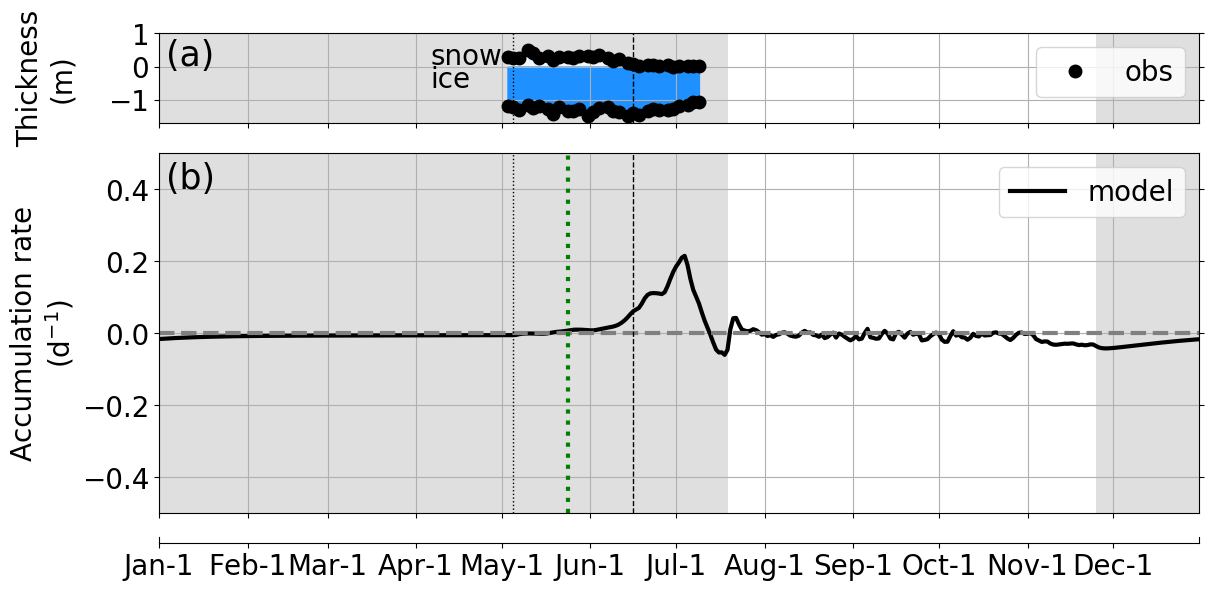

In [52]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.3,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.40,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.75,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')

    # --- ACCUMULATION RATE
    ax=axs[1]
    ymin=-0.5
    ymax= 0.5
    h1=ax.plot(first_year,array1d_iT_acc,
               '-',color='black',lw=3,label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Accumulation rate\n($\mathrm{ d^{-1} }$)')
    ax.grid()
    ax.legend(loc='upper right')
    ax.plot(xlims,[0,0],'k--',color='gray')
    plt.text(0.03,0.93,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,0.15])
    axs[1].set_position( [0.12,0.15  ,0.65,0.60])
    axs[2].set_position( [0.12,0.10  ,0.65,0.01])

with plt.style.context('thickness_PAR_nutrients_C_Chla_Kz_hBD_isolume.mplstyle'):
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(16,6))
    make_plots(axs)
    fig.align_ylabels(axs[:])

#     # --- SAVE
#     outfile='chl.0000000000.t001.r.png'
#     plt.savefig(outfile)

Figure <exp0_r>.
Model accumulation rates.
(a) Observed snow and ice thickness.
(b) Model accumulation rates for the reference simulation (EXP-0).

The vertical black dotted line is the date of the first PAR observations.
The vertical black dashed line is the date of the snow melt completion.
The green dotted line is the date of the simulated bloom initiation. 
The grey rectangles represent the time of year before the observed sea ice break-up and after the simulated sea ice freeze-up.

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated, 0-100m) chlorophyll $a$.

In [53]:
date_peak=np.nanargmax(array1d_iT_modvintchl)
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_peaks=\
datetime.datetime(year,1,1) + datetime.timedelta(date_peak.item())

Day of year

In [54]:
date_peak+1

193

In [55]:
date_peaks.strftime("%B %d")

'July 11'

In [56]:
c_P=array1d_iT_modvintchl[date_peak]

(in $mg\ Chl\ m^{-2}$)

In [57]:
c_P

59.013150917697374

## Model MITgcm: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

In [58]:
indir_exp0='.'
cphytofile=os.path.join(indir_exp0,'car.0000000000.t001.nc')
depth_end=100

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: diatoms

In [59]:
# mg Chl a m^-3
array2d_idepth_iT_modvintcphytodiatomfull\
=read_mitgcm.get_array2d_idepth_iT_diatombiofull(cphytofile)
# mg Chl a m^-2
array1d_iT_modvintcphytodiatomfull\
=vstats_pos.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modvintcphytodiatomfull,
    array1d_idepth_delR=drF,
    depth_end=depth_end)
array1d_iT_modvintcphytodiatom\
=array1d_iT_modvintcphytodiatomfull[array1d_iT1y_iT]

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: dinoflagellates

In [60]:
# mg Chl a m^-3
array2d_idepth_iT_modvintcphytodinofull\
=read_mitgcm.get_array2d_idepth_iT_dinobiofull(cphytofile)
# mg Chl a m^-2
array1d_iT_modvintcphytodinofull\
=vstats_pos.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modvintcphytodinofull,
    array1d_idepth_delR=drF,
    depth_end=depth_end)
array1d_iT_modvintcphytodino\
=array1d_iT_modvintcphytodinofull[array1d_iT1y_iT]

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: other nanophytoplankton

In [61]:
# mg Chl a m^-3
array2d_idepth_iT_modvintcphytootherfull\
=read_mitgcm.get_array2d_idepth_iT_otherbiofull(cphytofile)
array2d_idepth_iT_modvintcphytodiazofull\
=read_mitgcm.get_array2d_idepth_iT_diazobiofull(cphytofile)
array2d_idepth_iT_modvintcphytotrifull\
=read_mitgcm.get_array2d_idepth_iT_tribiofull(cphytofile)
array2d_idepth_iT_modvintcphytootherdiazotrifull\
=array2d_idepth_iT_modvintcphytootherfull\
+array2d_idepth_iT_modvintcphytodiazofull\
+array2d_idepth_iT_modvintcphytotrifull
# mg Chl a m^-2
array1d_iT_modvintcphytootherfull\
=vstats_pos.vint(
    array2d_idepth_iT_tracer\
    =array2d_idepth_iT_modvintcphytootherdiazotrifull,
    array1d_idepth_delR=drF,
    depth_end=depth_end)
array1d_iT_modvintcphytoother\
=array1d_iT_modvintcphytootherfull[array1d_iT1y_iT]

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: picophytoplankton

In [62]:
# mg Chl a m^-3
array2d_idepth_iT_modvintcphytoprofull\
=read_mitgcm.get_array2d_idepth_iT_probiofull(cphytofile)
array2d_idepth_iT_modvintcphytosynfull\
=read_mitgcm.get_array2d_idepth_iT_synbiofull(cphytofile)
array2d_idepth_iT_modvintcphytosmalleukfull\
=read_mitgcm.get_array2d_idepth_iT_smalleukbiofull(cphytofile)
array2d_idepth_iT_modvintcphytopicofull\
=array2d_idepth_iT_modvintcphytoprofull\
+array2d_idepth_iT_modvintcphytosynfull\
+array2d_idepth_iT_modvintcphytosmalleukfull
# mg Chl a m^-2
array1d_iT_modvintcphytopicofull\
=vstats_pos.vint(
    array2d_idepth_iT_tracer\
    =array2d_idepth_iT_modvintcphytopicofull,
    array1d_idepth_delR=drF,
    depth_end=depth_end)
array1d_iT_modvintcphytopico\
=array1d_iT_modvintcphytopicofull[array1d_iT1y_iT]

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: relative contribution

The relative contribution for validation purposes was calculated as a percentage of the biogeochemical functional group biomass vertically integrated (0-100m) from all the nanophytoplankton and microphytoplankton biomass.

In [63]:
array1d_iT_modvintcphyto\
=array1d_iT_modvintcphytodiatom+array1d_iT_modvintcphytodino\
+array1d_iT_modvintcphytoother
array1d_iT_modperccphytodiatom\
=array1d_iT_modvintcphytodiatom/array1d_iT_modvintcphyto*100
array1d_iT_modperccphytodino\
=array1d_iT_modvintcphytodino/array1d_iT_modvintcphyto*100
array1d_iT_modperccphytoother\
=array1d_iT_modvintcphytoother/array1d_iT_modvintcphyto*100

# Plot

## Plot: groups

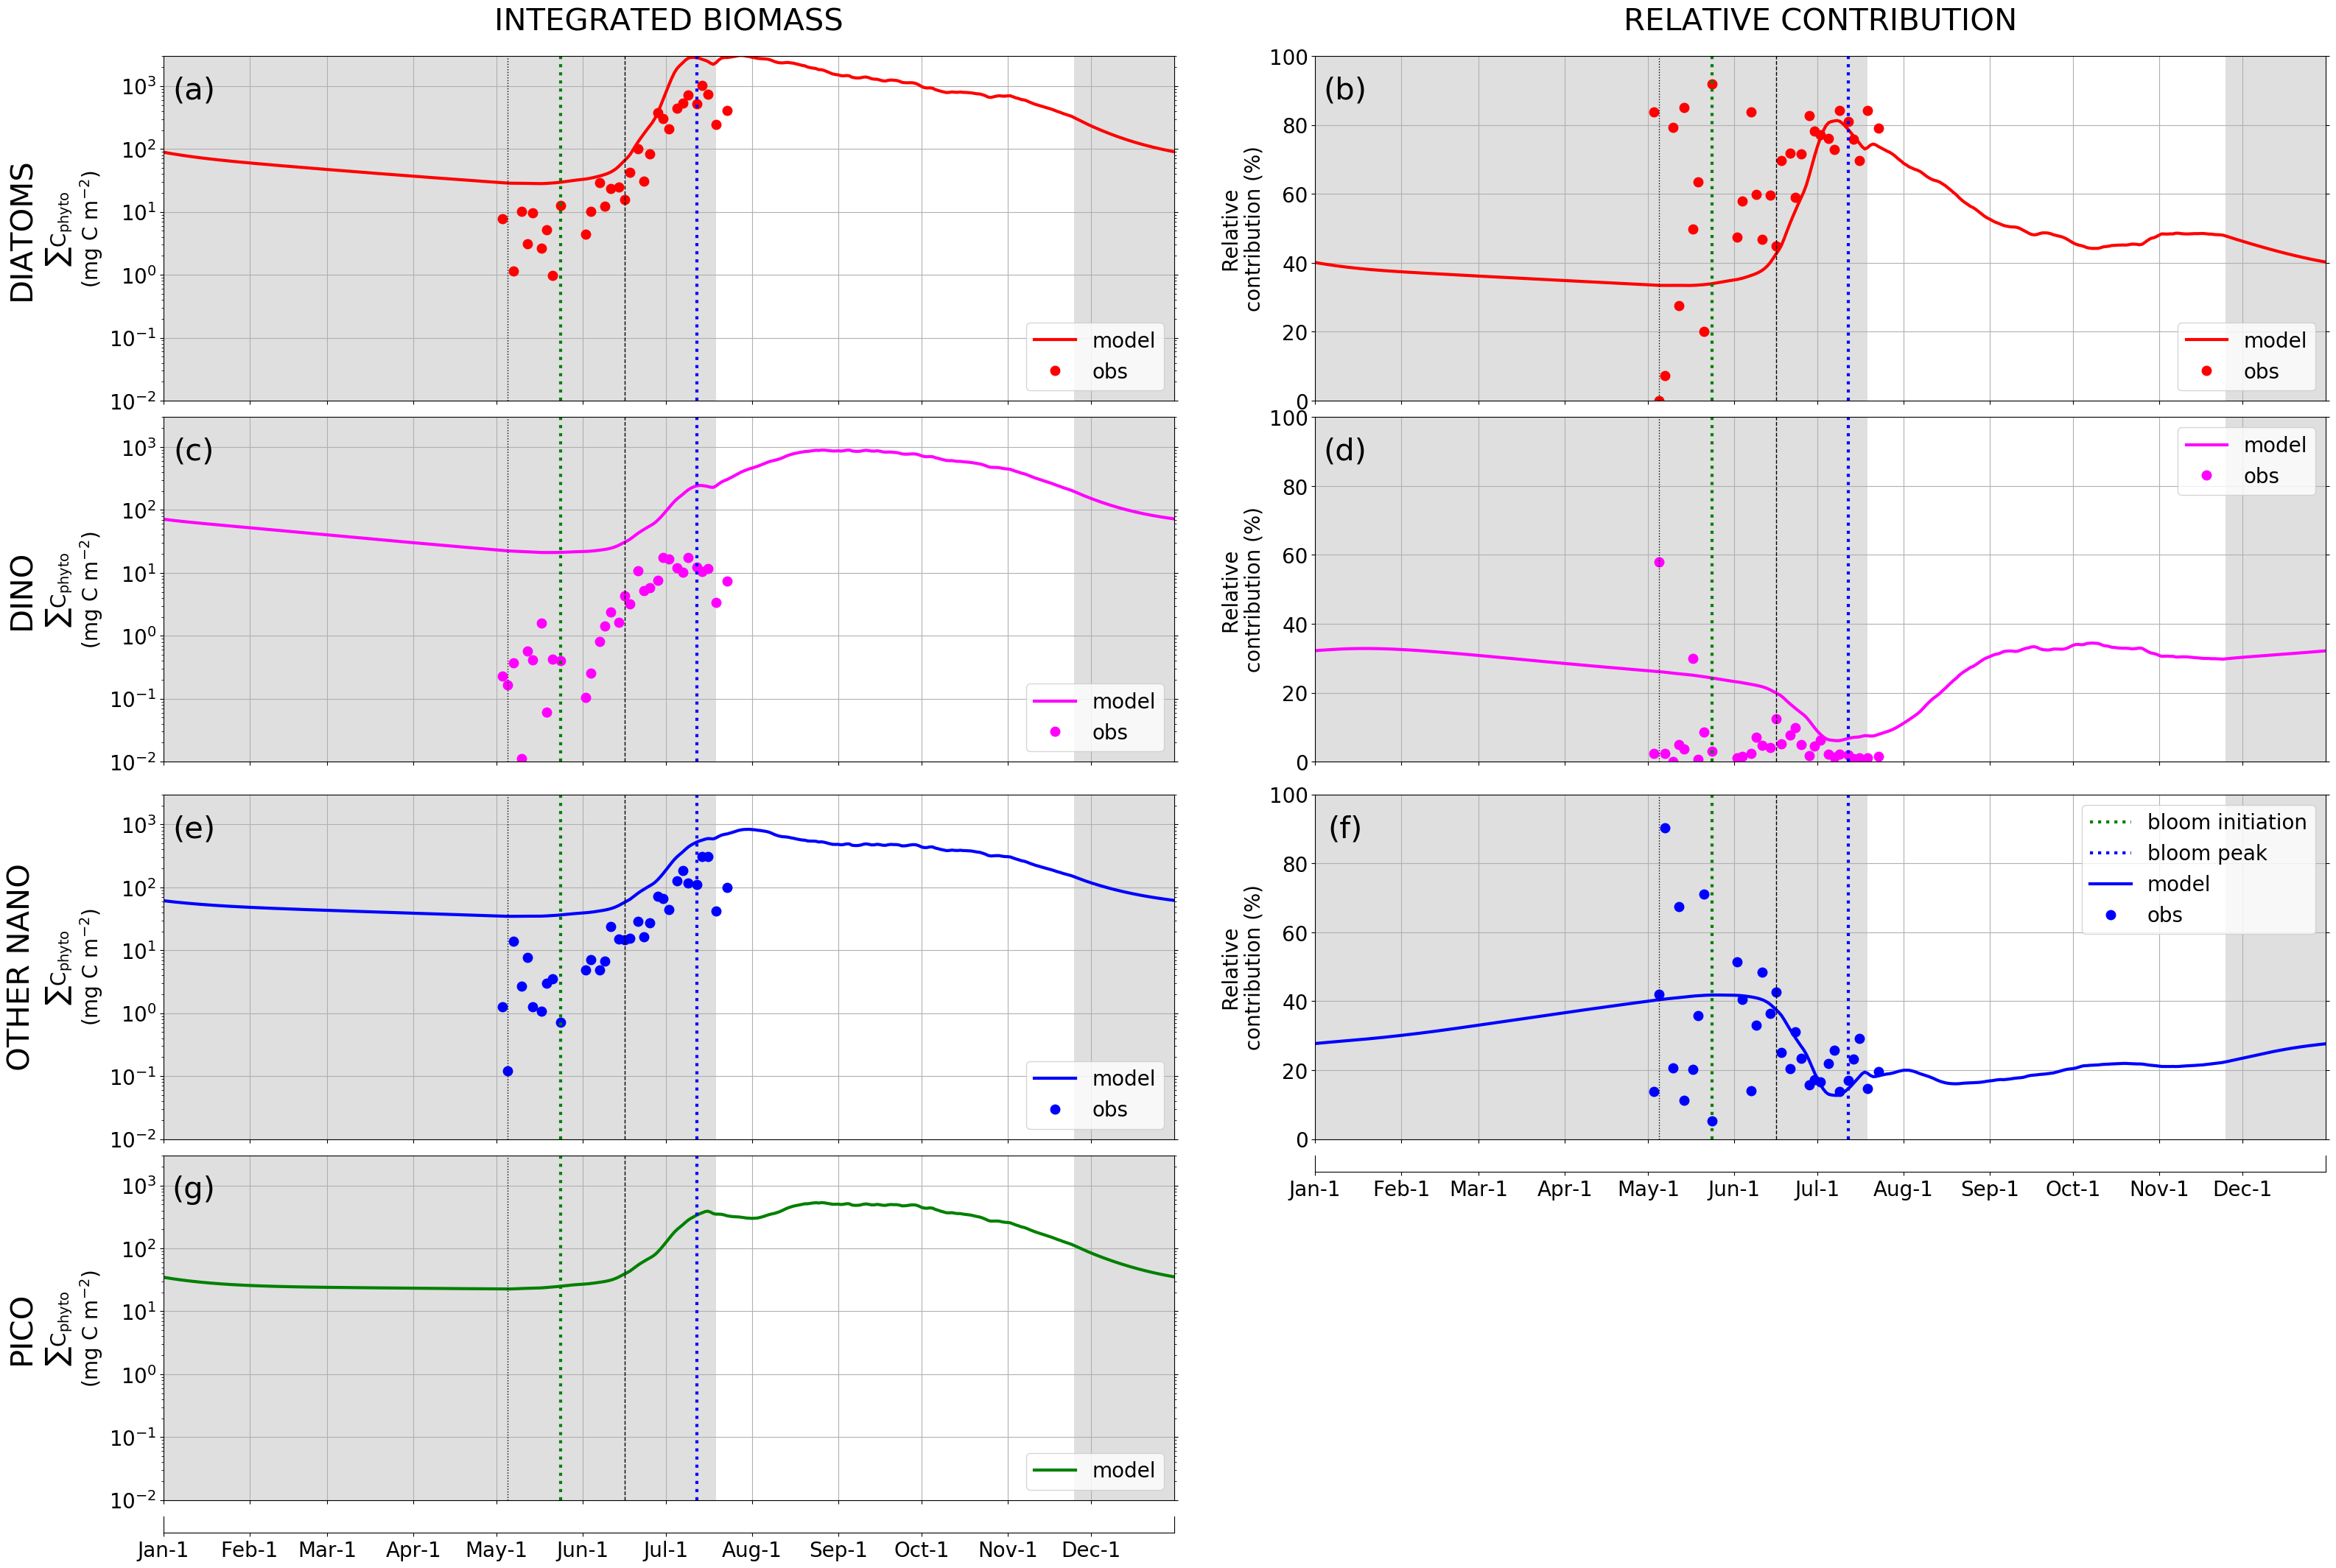

In [64]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]
    
    # --- SUM C_PHYTO DIATOMS
    ax=axs[0,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytodiatom,
               '-',color='red',label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphytodiatom,
               'o',color='red',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(-0.14,0.50,'DIATOMS',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.50,1.10,'INTEGRATED BIOMASS',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CONTRIBUTION DIATOMS
    ax=axs[0,1]
    ymin=0
    ymax=100
    
    h1=ax.plot(first_year,array1d_iT_modperccphytodiatom,
               '-',color='red',label='model')
    h2=ax.plot(first_year,array1d_iT_obsperccphytodiatom,
               'o',color='red',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Relative\n'
                  'contribution (%)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(0.50,1.10,'RELATIVE CONTRIBUTION',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- SUM C_PHYTO DINOFLAGELLATES
    ax=axs[1,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytodino,
               '-',color='magenta',label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphytodino,
               'o',color='magenta',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(-0.14,0.50,'DINO',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CONTRIBUTION DINO
    ax=axs[1,1]
    ymin=0
    ymax=100
    
    h1=ax.plot(first_year,array1d_iT_modperccphytodino,
               '-',color='magenta',label='model')
    h2=ax.plot(first_year,array1d_iT_obsperccphytodino,
               'o',color='magenta',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Relative\n'
                  'contribution (%)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='upper right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    # --- SUM C_PHYTO OTHER NANO
    ax=axs[2,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytoother,
               '-',color='blue',label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphytoother,
               'o',color='blue',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(-0.14,0.50,'OTHER NANO',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CONTRIBUTION OTHER NANO
    ax=axs[2,1]
    ymin=0
    ymax=100
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    h1=ax.plot(first_year,array1d_iT_modperccphytoother,
               '-',color='blue',label='model')
    h2=ax.plot(first_year,array1d_iT_obsperccphytoother,
               'o',color='blue',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Relative\n'
                  'contribution (%)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(f)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.legend(loc='upper right')
    
    # --- NOTHING
    ax=axs[3,0]
    ax.axis('off')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[3,1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- SUM C_PHYTO PICO
    ax=axs[4,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytopico,
               '-',color='green',label='model')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,'(g)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    plt.text(-0.14,0.50,'PICO',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    # --- NOTHING
    ax=axs[4,1]
    ax.axis('off')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[5,0]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- NOTHING
    ax=axs[5,1]
    ax.axis('off')
    
    
    # --- POSITION
    axs[0,0].set_position([0.07,0.72, 0.43,0.21])
    axs[0,1].set_position([0.56,0.72, 0.43,0.21])
    axs[1,0].set_position([0.07,0.50, 0.43,0.21])
    axs[1,1].set_position([0.56,0.50, 0.43,0.21])
    axs[2,0].set_position([0.07,0.27, 0.43,0.21])
    axs[2,1].set_position([0.56,0.27, 0.43,0.21])
    axs[3,0].set_position([0.07,0.25, 0.43,0.01])
    axs[3,1].set_position([0.56,0.25, 0.43,0.01])
    axs[4,0].set_position([0.07,0.05, 0.43,0.21])
    axs[4,1].set_position([0.56,0.05, 0.43,0.21])
    axs[5,0].set_position([0.07,0.03, 0.43,0.01])
    axs[5,1].set_position([0.56,0.02, 0.43,0.01])

with plt.style.context('groups.mplstyle'):
    # Plot
    fig,axs=plt.subplots(nrows=6,ncols=2,figsize=(31.90,22.28))
    make_plots(axs)

    # --- SAVE
    outfile='validation/groups.png'
    plt.savefig(outfile)

Figure <groups>.
Comparison to observations. Vertically integrated biomass of each functional group (0-100m, left). Relative contribution of each functional group to the total (diatoms+dinoflagellates+other nanophytoplankton) biomass (right). Note that picophytoplankton are not included in the analysis of the relative contribution as they were not part of the observations. The vertical grey dotted line is the date of the first PAR observations. The vertical grey dashed line is the date of the snow melt completion. The green dotted line is the date of the simulated bloom initiation. The blue dotted line is the date of the simulated bloom peak. The grey rectangles represent the time of year before the sea ice break-up and after the sea ice freeze-up.